## Prediction Using 2-layer Feed forward network

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import Dataset, DataLoader

In [3]:
force1=pd.read_csv('FlowStress_Prediction.csv')

In [4]:
force1['strain']=np.log(force1['sch_entry_thickness']/force1['sch_exit_thickness'])
force1['strain_rate']=force1['strain']*force1['meas_speed_fpm']/np.sqrt(0.5*force1['avgrolldiam']*(force1['sch_entry_thickness']-force1['sch_exit_thickness']))
force1['ln_strain']=np.log(force1['strain'])
force1['ln_strain_rate']=np.log(force1['strain_rate'])
force1['core_temp']=force1['meas_entry_temp']+5/9*0.75*force1['model_target_gauge']*(force1['meas_entry_temp']**4/308300000000+(force1['meas_entry_temp']-70)**1.25/1412)
R=8.314
force1['1/RT']=1/(R*force1['core_temp'])

In [5]:
a=force1.loc[force1['model_grade']=='01010095FH1 ']

In [6]:
a = a.dropna(subset=['1/RT'])

In [7]:
RT= a['1/RT']
strain_rate = a['strain_rate']
measured_values = a['meas_flow_stress']
temp=a['core_temp']

In [8]:
input_features = a[['core_temp','strain','strain_rate','meas_flow_stress']].values

scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(a[['core_temp','strain','strain_rate','meas_flow_stress']])


In [9]:
# Convert to PyTorch tensor
x_train = torch.tensor(scaled_data, dtype=torch.float32)

In [10]:
# Define the neural network model
class ZenerHollomonModel(nn.Module):
    def __init__(self):
        super(ZenerHollomonModel, self).__init__()
        self.fc1 = nn.Linear(4, 64)  # First layer: 3 input features, 64 hidden units
        self.fc2 = nn.Linear(64, 4)   # Second layer: 64 hidden units, 4 output units 

    def forward(self, x):
        x = torch.relu(self.fc1(x))  # Apply ReLU activation to the output of the first layer
        x = self.fc2(x)              # Output layer, no activation function for coefficients
        return x

In [11]:
# Define the loss function and optimizer
model = ZenerHollomonModel()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [12]:
# Train the model
num_epochs = 5000
for epoch in range(num_epochs):
    optimizer.zero_grad()
    outputs = model(x_train)
    
    # Assuming you have the ground truth coefficients from another source
    # For demonstration, randomly generate target coefficients
    target_coefficients = torch.tensor(a['meas_flow_stress'].values).float().view(-1, 1)
    
    loss = criterion(outputs, target_coefficients)
    loss.backward()
    optimizer.step()

    if (epoch+1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')


C:\Users\SDEY\AppData\Local\anaconda3\envs\pyt-env\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([164, 1])) that is different to the input size (torch.Size([164, 4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [100/5000], Loss: 33.7459
Epoch [200/5000], Loss: 1.7833
Epoch [300/5000], Loss: 1.3313
Epoch [400/5000], Loss: 1.2609
Epoch [500/5000], Loss: 1.1870
Epoch [600/5000], Loss: 1.1106
Epoch [700/5000], Loss: 1.0323
Epoch [800/5000], Loss: 0.9525
Epoch [900/5000], Loss: 0.8442
Epoch [1000/5000], Loss: 0.6708
Epoch [1100/5000], Loss: 0.5167
Epoch [1200/5000], Loss: 0.3918
Epoch [1300/5000], Loss: 0.2916
Epoch [1400/5000], Loss: 0.2111
Epoch [1500/5000], Loss: 0.1495
Epoch [1600/5000], Loss: 0.1032
Epoch [1700/5000], Loss: 0.0691
Epoch [1800/5000], Loss: 0.0450
Epoch [1900/5000], Loss: 0.0285
Epoch [2000/5000], Loss: 0.0176
Epoch [2100/5000], Loss: 0.0108
Epoch [2200/5000], Loss: 0.0067
Epoch [2300/5000], Loss: 0.0043
Epoch [2400/5000], Loss: 0.0029
Epoch [2500/5000], Loss: 0.0021
Epoch [2600/5000], Loss: 0.0016
Epoch [2700/5000], Loss: 0.0013
Epoch [2800/5000], Loss: 0.0011
Epoch [2900/5000], Loss: 0.0009
Epoch [3000/5000], Loss: 0.0008
Epoch [3100/5000], Loss: 0.0007
Epoch [3200/5000

In [13]:
# Use the model for prediction
with torch.no_grad():
    predicted_coefficients = model(x_train)
    
# Denormalize the predictions
predicted_values = scaler.inverse_transform(predicted_coefficients)
print(predicted_values)

[[3.25173033e+03 3.83787957e-01 3.13226932e+01 2.64745477e+01]
 [5.25756599e+03 7.56860141e-01 5.90786114e+01 4.99218187e+01]
 [7.17489366e+03 1.11185568e+00 8.57210516e+01 7.22397114e+01]
 [7.67494960e+03 1.20441270e+00 9.26599445e+01 7.80810563e+01]
 [7.92548672e+03 1.25092352e+00 9.61745659e+01 8.09144721e+01]
 [8.17544100e+03 1.29734371e+00 9.96164442e+01 8.39122440e+01]
 [8.50836628e+03 1.35869161e+00 1.04264829e+02 8.77058856e+01]
 [8.92310322e+03 1.43561915e+00 1.09985621e+02 9.26614724e+01]
 [9.33908667e+03 1.51235646e+00 1.15780844e+02 9.74414266e+01]
 [1.01683363e+04 1.66602835e+00 1.27241546e+02 1.07286680e+02]
 [7.00363437e+03 1.08087843e+00 8.33384611e+01 7.03740283e+01]
 [7.75641219e+03 1.21926145e+00 9.38332891e+01 7.89677487e+01]
 [3.77424307e+03 4.82315373e-01 3.85362305e+01 3.25162615e+01]
 [6.25743341e+03 9.41800029e-01 7.29623817e+01 6.15765532e+01]
 [7.75821064e+03 1.21978972e+00 9.38227283e+01 7.90367585e+01]
 [8.09103726e+03 1.28121983e+00 9.84229626e+01 8.296039

### Values of the coefficients

In [16]:
predicted_coeff_values=model.fc2.weight.data.numpy()

In [31]:
print(predicted_coeff_values)

[[ 3.35240483e-01  1.79267943e+00  4.76928830e-01  1.23911731e-01
   3.68860811e-02 -2.47182082e-02  1.57278210e-01  2.22660422e-01
   2.97966748e-01  2.70078510e-01 -8.15862566e-02  3.60130146e-02
   1.61855265e-01 -7.74114430e-02  2.28120908e-01  1.86698884e-01
   9.96152014e-02  3.64764899e-01  2.86667645e-01  2.58689255e-01
  -7.16041028e-03  4.69887406e-02 -2.18186695e-02  3.89913827e-01
   5.11631489e-01  1.24381490e-01  9.56463069e-02  6.45032525e-03
   3.26993704e-01  7.56748766e-02 -3.53364199e-02  2.59266734e-01
   1.83888841e-02  3.46746951e-01  1.28685981e-01  1.19221404e-01
   8.11605304e-02  1.19998872e-01  3.11432511e-01  9.72233415e-02
   2.24732503e-01 -1.04991183e-01  2.49326125e-01  3.22504342e-01
   2.10214108e-01  4.68070030e-01 -6.38240278e-02  1.22238696e-03
   3.77406180e-03 -7.60730505e-02  2.39412308e-01  1.09991446e-01
  -3.42549309e-02  6.57108799e-02  1.18017353e-01 -8.96985382e-02
   1.62979573e-01 -2.14821592e-01  2.99394280e-01  2.12012589e-01
   2.16662

### Taking a mean to get an aggregate, there could be a better approach to it.

In [24]:
c_core_temp=np.mean(predicted_coeff_values[0:1])
print(c_core_temp)

0.17645204


In [30]:
c_strain=np.mean(predicted_coeff_values[1:2])
print(c_strain)

0.17253548
[[ 3.35240483e-01  1.79267943e+00  4.76928830e-01  1.23911731e-01
   3.68860811e-02 -2.47182082e-02  1.57278210e-01  2.22660422e-01
   2.97966748e-01  2.70078510e-01 -8.15862566e-02  3.60130146e-02
   1.61855265e-01 -7.74114430e-02  2.28120908e-01  1.86698884e-01
   9.96152014e-02  3.64764899e-01  2.86667645e-01  2.58689255e-01
  -7.16041028e-03  4.69887406e-02 -2.18186695e-02  3.89913827e-01
   5.11631489e-01  1.24381490e-01  9.56463069e-02  6.45032525e-03
   3.26993704e-01  7.56748766e-02 -3.53364199e-02  2.59266734e-01
   1.83888841e-02  3.46746951e-01  1.28685981e-01  1.19221404e-01
   8.11605304e-02  1.19998872e-01  3.11432511e-01  9.72233415e-02
   2.24732503e-01 -1.04991183e-01  2.49326125e-01  3.22504342e-01
   2.10214108e-01  4.68070030e-01 -6.38240278e-02  1.22238696e-03
   3.77406180e-03 -7.60730505e-02  2.39412308e-01  1.09991446e-01
  -3.42549309e-02  6.57108799e-02  1.18017353e-01 -8.96985382e-02
   1.62979573e-01 -2.14821592e-01  2.99394280e-01  2.12012589e-01

In [29]:
c_strain_rate=np.mean(predicted_coeff_values[0:1])
print(c_strain_rate)

0.17645204


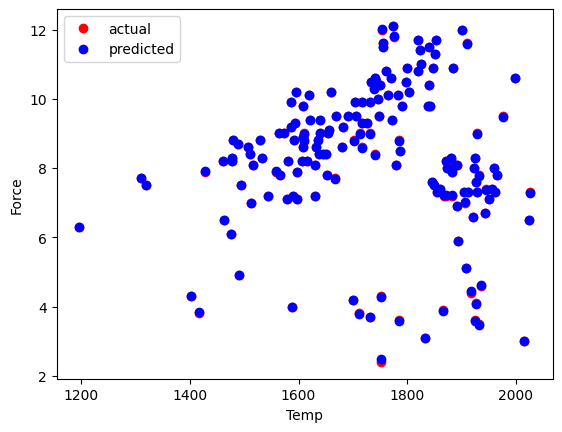

In [15]:
plt.plot(a['core_temp'],measured_values,'ro',label='actual')
plt.plot(a['core_temp'],predicted_coefficients[:,3],'bo',label='predicted')
plt.xlabel('Temp')
plt.ylabel('Force')
plt.legend()
plt.show()

## Loss : 0.0015

As can be seen from the plot above, the prediction is pretty good.
- It can be made better by increasing the number of epochs.
- The training currently is on the entire dataset, it would be worthwhile to split it into training and test data and recheck the loss.